<center>基于波函数的流体超分辨研究</center>

传统的超分辨是给定图片a，经过超分辨能够得到精度更高的图片b

我们希望能够在超分辨模型前后进行结构的调整，使得其能够自适应涡旋流体超分辨，为方便后续研究，我们暂且将这个方法的名字成为$Clebsch$流体超分辨。

$Clebsch$流体超分辨分为四个步骤：
我们首先有一些流体的图片集，我们是能够已知其图片的结构的，即网格数据，和网格对应的速度场。
其次，我们能够知道双分量波函数是可以经过公式转换得到对应速度场的，双分量波函数形如$\psi = a+bi+cj+dk$

1. 从任意一张已知的图片出发，我们假设该图片是$128\times 128$，经过$model_A$后我们能够找到$a,b,c,d$，与之对应的，$a,b,c,d$每一个单独的量都应该是$128\times 128$

2. 我们将得到的$a,b,c,d$再经过一个$model_B$，这个$model_B$是一个超分辨模型，然后我们将得到对应的$a,b,c,d$，我们假设其分辨率从128提高到了256

3. 我们需要再训练一个从abcd到速度场的$model_c$，然后我们就能得到256的速度场了。

我们希望经过我们改进后的超分辨模型，能够更加适应用于涡旋的流体现象，因为我们能够chern的文章中验证通过波函数的方法能够较好的捕捉涡结构。


为了能够得到上面的模型，我们需要逐步训练各个部分模型，这项工作，只是进行一个简单的尝试，因此，我们会对采用精度较低的图片，以提高模型的训练速度，来验证本项工作的可行性。

# model_A 训练
我们首先进行$model_A $的训练，即：

给定一个速度场后，训练得到波函数的$a,b,c,d$分量。



## 一维问题

我们首先构造较为简单的一维算例

$$
a = \frac{1}{2\sqrt{\pi}}cos(\frac{x}{\bar h})\\
b = \frac{1}{2\sqrt{\pi}}sin(\frac{x}{\bar h})\\
c = \frac{1}{2\sqrt{\pi}}cos(\frac{x}{\bar h})\\
d = \frac{1}{2\sqrt{\pi}}sin(\frac{x}{\bar h})\\
$$

$$
x\in(-\pi, \pi)\\
t\in(0, 10)\\
\bar h=1
$$
因此，双分量波函数可以表示为如下形式:
$$
\mathbf{\psi}=[\psi_1, \psi_2]^T=\frac{1}{2\sqrt{\pi}}[cos(x)+isin(x + t), cos(x + t)+isin(x - t)]^T
$$
根据公式
$$
u = \hbar \langle \nabla \psi, i \psi \rangle_{\mathbb{R}} = \hbar (a \nabla b - b \nabla a + c \nabla d - d \nabla c),

$$

我们可以计算出对应的速度场为：
$$
u=\frac{1}{2\pi h}cos(\frac{2x}{h})
$$

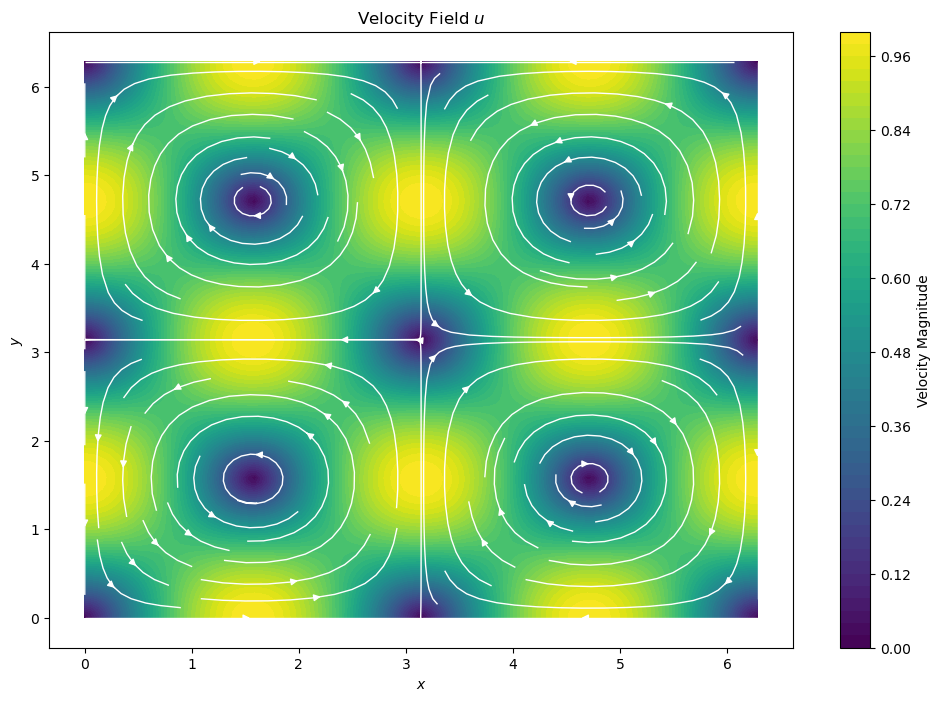

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义常数
hbar = 1

# 定义 H(x)
def H(x):
    return np.where((0 <= x) & (x <= np.pi), x / 2, np.pi - x / 2)

# 定义函数 a, b, c, d
def a(x, y):
    return np.cos(H(x)) * np.cos(np.cos(y) * (2 - np.cos(x)) / hbar)

def b(x, y):
    return np.cos(H(x)) * np.sin(np.cos(y) * (2 - np.cos(x)) / hbar)

def c(x, y):
    return np.sin(H(x)) * np.cos(np.cos(y) * (2 + np.cos(x)) / hbar)

def d(x, y):
    return -np.sin(H(x)) * np.sin(np.cos(y) * (2 + np.cos(x)) / hbar)

# 计算梯度
def gradient(f, x, y, eps=1e-5):
    f_x = (f(x + eps, y) - f(x - eps, y)) / (2 * eps)
    f_y = (f(x, y + eps) - f(x, y - eps)) / (2 * eps)
    return f_x, f_y

# 计算速度场
def compute_velocity_field(x, y):
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = gradient(a, x, y)
    b_grad_x, b_grad_y = gradient(b, x, y)
    c_grad_x, c_grad_y = gradient(c, x, y)
    d_grad_x, d_grad_y = gradient(d, x, y)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

# 创建网格
x = np.linspace(0, 2 * np.pi, 100)
y = np.linspace(0, 2 * np.pi, 100)
X, Y = np.meshgrid(x, y)

# 计算速度场
U_x, U_y = compute_velocity_field(X, Y)

# 计算速度场的大小
U_magnitude = np.sqrt(U_x**2 + U_y**2)

# 绘制速度场
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, U_magnitude, levels=50, cmap='viridis')
plt.colorbar(label='Velocity Magnitude')
plt.streamplot(X, Y, U_x, U_y, color='white', linewidth=1)
plt.title('Velocity Field $u$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()


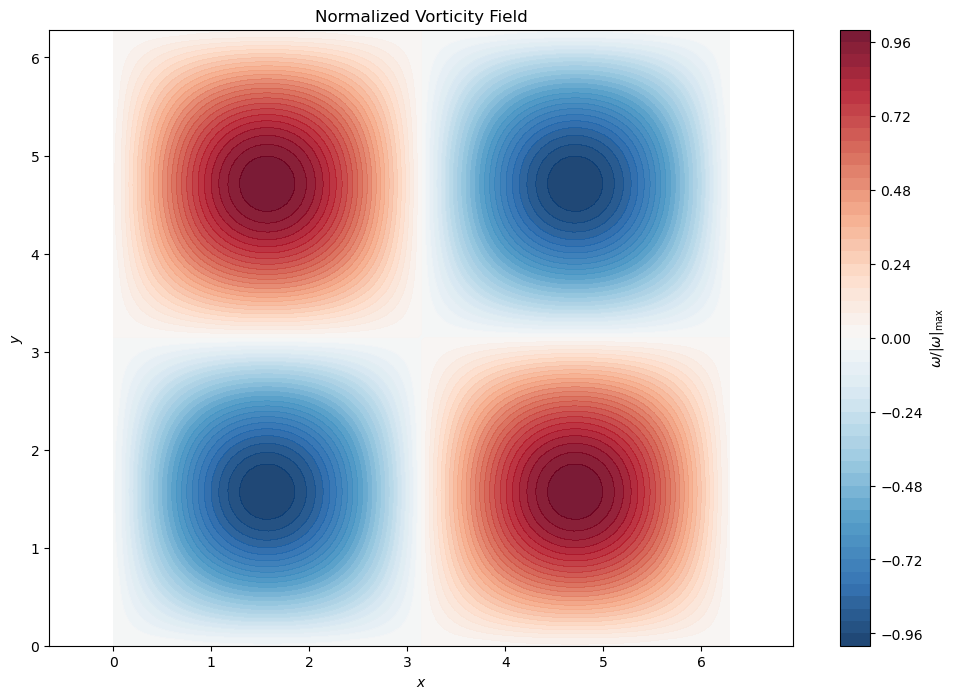

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义常数
hbar = 1

# 定义 H(x)
def H(x):
    return np.where((0 <= x) & (x <= np.pi), x / 2, np.pi - x / 2)

# 定义函数 a, b, c, d
def a(x, y):
    return np.cos(H(x)) * np.cos(np.cos(y) * (2 - np.cos(x)) / hbar)

def b(x, y):
    return np.cos(H(x)) * np.sin(np.cos(y) * (2 - np.cos(x)) / hbar)

def c(x, y):
    return np.sin(H(x)) * np.cos(np.cos(y) * (2 + np.cos(x)) / hbar)

def d(x, y):
    return -np.sin(H(x)) * np.sin(np.cos(y) * (2 + np.cos(x)) / hbar)

# 计算梯度
def gradient(f, x, y, eps=1e-5):
    f_x = (f(x + eps, y) - f(x - eps, y)) / (2 * eps)
    f_y = (f(x, y + eps) - f(x, y - eps)) / (2 * eps)
    return f_x, f_y

# 计算速度场
def compute_velocity_field(x, y, dx, dy):
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = np.gradient(a_val, dx, dy)
    b_grad_x, b_grad_y = np.gradient(b_val, dx, dy)
    c_grad_x, c_grad_y = np.gradient(c_val, dx, dy)
    d_grad_x, d_grad_y = np.gradient(d_val, dx, dy)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

# 创建网格
x = np.linspace(0, 2 * np.pi, 100)
y = np.linspace(0, 2 * np.pi, 100)
X, Y = np.meshgrid(x, y)

# 计算步长
dx = x[1] - x[0]
dy = y[1] - y[0]

# 计算速度场
U_x, U_y = compute_velocity_field(X, Y, dx, dy)

# 计算旋度
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy

# 计算旋度
vort = vorticity(U_x, U_y, dx, dy)

# 归一化旋度
max_vort = np.max(np.abs(vort))
vort_normalized = vort / max_vort if max_vort != 0 else vort

# 绘制归一化后的旋度场
plt.figure(figsize=(12, 8))
contour = plt.contourf(X, Y, vort_normalized, levels=50, cmap='RdBu_r', alpha=0.9)
plt.colorbar(contour, label='$\omega / |\omega|_{\mathrm{max}}$')
plt.title('Normalized Vorticity Field')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axis('equal')
plt.show()


In [11]:
import sympy as sp

# 定义变量
a, b, c, d = sp.symbols('a b c d')

# 定义s1, s2, s3
s1 = a**2 + b**2 - c**2 - d**2
s2 = 2 * (b*c - a*d)
s3 = 2 * (a*c + b*d)

# 计算s1^2, s2^2, s3^2
s1_squared = sp.expand(s1**2)
s2_squared = sp.expand(s2**2)
s3_squared = sp.expand(s3**2)

# 将每个分量的平方相加
sum_of_squares = s1_squared + s2_squared + s3_squared

# 展开并简化结果
simplified_sum_of_squares = sp.simplify(sum_of_squares)

# 可视化每一步骤
steps = {
    's1^2': s1_squared,
    's2^2': s2_squared,
    's3^2': s3_squared,
    'Sum of squares': sum_of_squares,
    'Simplified sum': simplified_sum_of_squares
}

# 使用LaTeX格式输出
for step, result in steps.items():
    display(sp.Eq(sp.Symbol(step), result))


Eq(s1^2, a**4 + 2*a**2*b**2 - 2*a**2*c**2 - 2*a**2*d**2 + b**4 - 2*b**2*c**2 - 2*b**2*d**2 + c**4 + 2*c**2*d**2 + d**4)

Eq(s2^2, 4*a**2*d**2 - 8*a*b*c*d + 4*b**2*c**2)

Eq(s3^2, 4*a**2*c**2 + 8*a*b*c*d + 4*b**2*d**2)

Eq(Sum of squares, a**4 + 2*a**2*b**2 + 2*a**2*c**2 + 2*a**2*d**2 + b**4 + 2*b**2*c**2 + 2*b**2*d**2 + c**4 + 2*c**2*d**2 + d**4)

Eq(Simplified sum, a**4 + 2*a**2*b**2 + 2*a**2*c**2 + 2*a**2*d**2 + b**4 + 2*b**2*c**2 + 2*b**2*d**2 + c**4 + 2*c**2*d**2 + d**4)

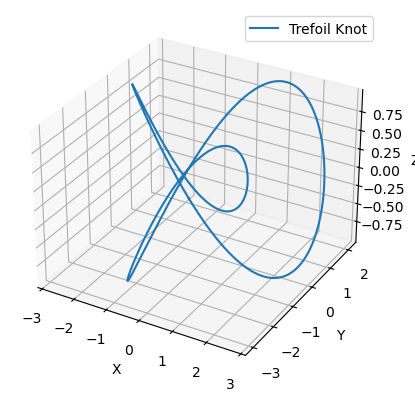

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 参数化三叶结
theta = np.linspace(0, 2*np.pi, 1000)
x = np.sin(theta) + 2*np.sin(2*theta)
y = np.cos(theta) - 2*np.cos(2*theta)
z = -np.sin(3*theta)

# 创建3D图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三叶结
ax.plot(x, y, z, label='Trefoil Knot')
ax.legend()

# 设置轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 显示图形
plt.show()


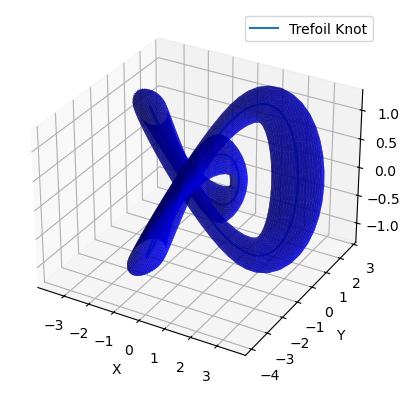

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 参数化三叶结的曲线
theta = np.linspace(0, 2 * np.pi, 1000)
x = np.sin(theta) + 2 * np.sin(2 * theta)
y = np.cos(theta) - 2 * np.cos(2 * theta)
z = -np.sin(3 * theta)

# 创建3D图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三叶结的曲线
ax.plot(x, y, z, label='Trefoil Knot')
ax.legend()

# 设置轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 参数化三叶结的表面
phi = np.linspace(0, 2 * np.pi, 100)
theta = np.linspace(0, 2 * np.pi, 100)
phi, theta = np.meshgrid(phi, theta)
r = 0.3  # 管道半径
R = 1  # 三叶结的半径

# 定义三叶结表面的参数方程
X = (R + r * np.cos(phi)) * (np.sin(theta) + 2 * np.sin(2 * theta))
Y = (R + r * np.cos(phi)) * (np.cos(theta) - 2 * np.cos(2 * theta))
Z = r * np.sin(phi) - np.sin(3 * theta)

# 绘制三叶结的表面
ax.plot_surface(X, Y, Z, color='b', alpha=0.7)

# 显示图形
plt.show()


In [25]:
import numpy as np
from scipy.optimize import minimize

# 定义普朗克常数的约化值 hbar
hbar = 1.0545718e-34  # 约化普朗克常数，单位为 J·s

# 假设我们有一个速度场 u(x, y, z)
def velocity_field(x, y, z):
    u_x = x
    u_y = y
    u_z = z
    return np.array([u_x, u_y, u_z])

# 定义能量函数 E^ε(ψ)
def energy_function(psi_flat, x, y, z, epsilon):
    psi = psi_flat.reshape(x.shape)
    u = velocity_field(x, y, z)
    
    # 计算梯度
    grad_psi = np.array(np.gradient(psi, x[0,0,:], y[0,:,0], z[:,0,0]))
    
    # 计算能量
    term1 = np.sum(np.abs(u - 1j * grad_psi)**2) / hbar**2
    term2 = epsilon / 4 * np.sum(np.abs(grad_psi)**2)
    energy = term1 + term2
    
    return energy

# 初始波函数猜测
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
z = np.linspace(-1, 1, 10)
X, Y, Z = np.meshgrid(x, y, z)
psi_initial = np.exp(-(X**2 + Y**2 + Z**2))

# 展平初始波函数
psi_initial_flat = psi_initial.flatten()

# 定义正则化参数 ε
epsilon = 0.1

# 最小化能量函数以找到波函数
result = minimize(energy_function, psi_initial_flat, args=(X, Y, Z, epsilon), method='L-BFGS-B')

# 最优波函数
psi_optimal_flat = result.x
psi_optimal = psi_optimal_flat.reshape(X.shape)

# 输出结果
print("最优波函数:", psi_optimal)
psi_optimal.shape

c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\function_base.py:1238: RuntimeWarning: divide by zero encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\function_base.py:1259: RuntimeWarning: divide by zero encountered in divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\function_base.py:1266: RuntimeWarning: divide by zero encountered in divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
C:\Users\user\AppData\Local\Temp\ipykernel_26368\2021657967.py:23: RuntimeWarning: invalid value encountered in multiply
  term1 = np.sum(np.abs(u - 1j * grad_psi)**2) / hbar**2
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


最优波函数: [[[0.04978707 0.0739077  0.09939614 0.12110333 0.13367475 0.13367475
   0.12110333 0.09939614 0.0739077  0.04978707]
  [0.0739077  0.10971419 0.14755117 0.17977497 0.19843693 0.19843693
   0.17977497 0.14755117 0.10971419 0.0739077 ]
  [0.09939614 0.14755117 0.19843693 0.24177371 0.26687159 0.26687159
   0.24177371 0.19843693 0.14755117 0.09939614]
  [0.12110333 0.17977497 0.24177371 0.29457483 0.32515386 0.32515386
   0.29457483 0.24177371 0.17977497 0.12110333]
  [0.13367475 0.19843693 0.26687159 0.32515386 0.35890722 0.35890722
   0.32515386 0.26687159 0.19843693 0.13367475]
  [0.13367475 0.19843693 0.26687159 0.32515386 0.35890722 0.35890722
   0.32515386 0.26687159 0.19843693 0.13367475]
  [0.12110333 0.17977497 0.24177371 0.29457483 0.32515386 0.32515386
   0.29457483 0.24177371 0.17977497 0.12110333]
  [0.09939614 0.14755117 0.19843693 0.24177371 0.26687159 0.26687159
   0.24177371 0.19843693 0.14755117 0.09939614]
  [0.0739077  0.10971419 0.14755117 0.17977497 0.19843693

(10, 10, 10)